<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="http://bokeh.pydata.org/">     
           <img 
               src="assets/images/bokeh-transparent.png" 
               style="width:50px"
           >
           </a>    
       </td>
       <td style="border:none">
           <h1>Bokeh Tutorial</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>12. HoloViews and Bokeh</h2></div>

Bokeh is designed to make it possible to construct rich, deeply interactive browser-based visualizations from Python source code.  It has a syntax more compact and natural than older libraries like Matplotlib, particularly when using the Charts API, but it still requires a good bit of code to do relatively common data-science tasks like complex multi-figure layouts, animations, and widgets for parameter space exploration.

To make it feasible to generate complex interactive visualizations "on the fly" in Jupyter notebooks while exploring data, we have created the new [HoloViews](http://holoviews.org) library built on top of Bokeh.  

HoloViews allows you to annotate your data with a small amount of metadata that makes it instantly visualizable, usually without writing any plotting code.  HoloViews makes it practical to explore datasets and visualize them from every angle interactively, wrapping up Bokeh code for common tasks into a set of configurable and composable components.  HoloViews installs separately from Bokeh, e.g. using `conda install holoviews`, and also works with matplotlib.

In [1]:
import holoviews as hv
import numpy as np
hv.notebook_extension(bokeh=False)

# A simple function

First, let us define a mathematical function to explore, using the Numpy array library:

In [2]:
def sine(x, phase=0, freq=100):
    return np.sin((freq * x + phase))

We will examine the effect of varying phase and frequency:

In [3]:
phases = np.linspace(0,2*np.pi,11) # Explored phases
freqs = np.linspace(50,150,5)      # Explored frequencies

Over a specific spatial area, sampled on a grid:

In [4]:
dist = np.linspace(-0.5,0.5,202)   # Linear spatial sampling
x,y = np.meshgrid(dist, dist)
grid = (x**2+y**2)                 # 2D spatial sampling

# Succinct data visualization

With HoloViews, we can immediately view our simple function as an image in a Bokeh plot in the Jupyter notebook, without any coding:

b':Image   [x,y]   (z)'
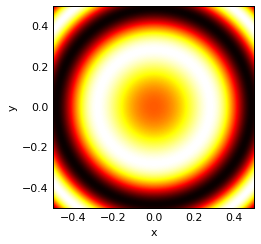

In [5]:
hv.Image(sine(grid, freq=20))

But we can just as easily use ``+`` to combine ``Image`` and ``Curve`` objects, visualizing both the 2D array (with associated histogram) and a 1D cross-section:

:Layout
   .AdjointLayout.Sine_Grating :AdjointLayout
      :Histogram   [z]   (Frequency)
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .Curve.Sine_Wave            :Curve   [x]   (z)
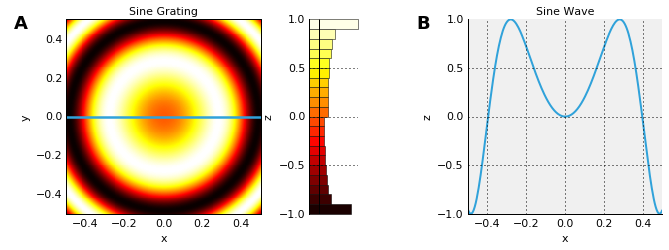

In [6]:
grating = hv.Image(sine(grid, freq=20), label="Sine Grating")

((grating * hv.HLine(y=0)).hist() + grating.sample(y=0).relabel("Sine Wave"))

Here you can see that a HoloViews object isn't really a plot (though it generates a Bokeh Plot when requested for display by the Jupyter notebook); it is just a wrapper around your data, and the data can be processed directly (as when taking the cross-section using `sample()` here).  In fact, your raw data is always available, allowing you to go back and forth between visualizations and numerical analysis easily and flexibly:

In [7]:
grating[0,0]

0.00024751862324920763

In [8]:
type(grating.data)

numpy.ndarray

Here the underlying data is the original Numpy array, but Python dictionaries as well as Pandas and other data formats can also be supplied.

# Interactive exploration

HoloViews is designed to explore complicated datasets, where there can often be much more data than can be shown on screen at once.  If there are dimensions to your data that have not been laid out as adjacent plots or overlaid plots, then HoloViews will automatically generate sliders covering the remaining range of the data.  For instance, if we add an additional dimension `Y` indicating the location of the cross-section, we'll get a slider for `Y`:

:Layout
   .HoloMap.Sine_Grating :HoloMap   [Y]
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .HoloMap.I            :HoloMap   [Y]
      :Curve   [x]   (z)
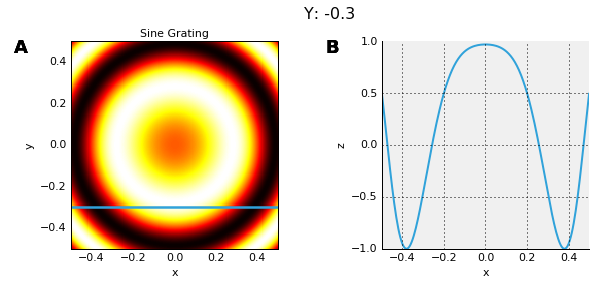
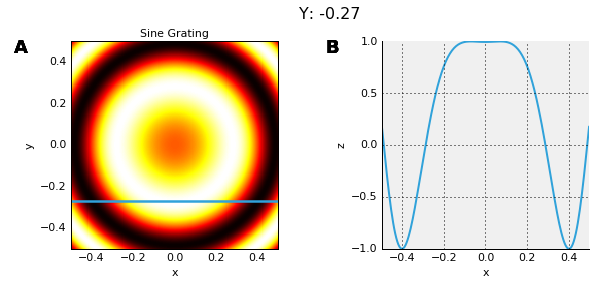
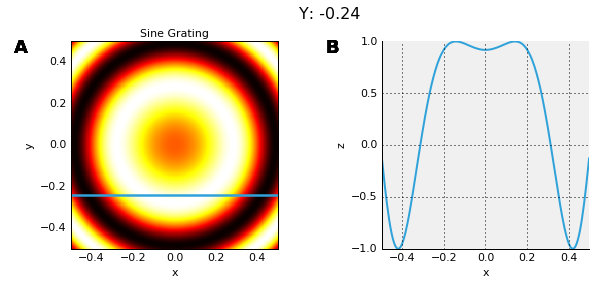
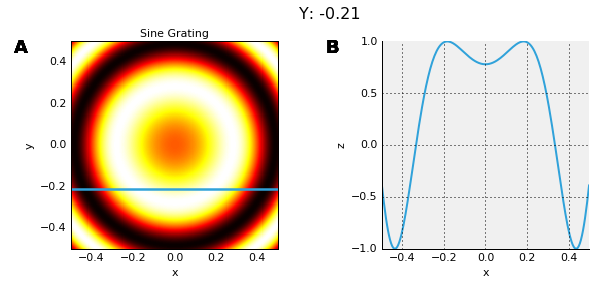
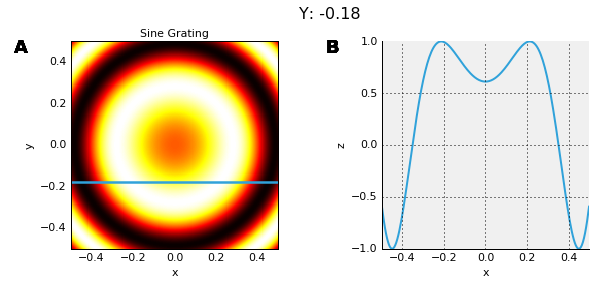
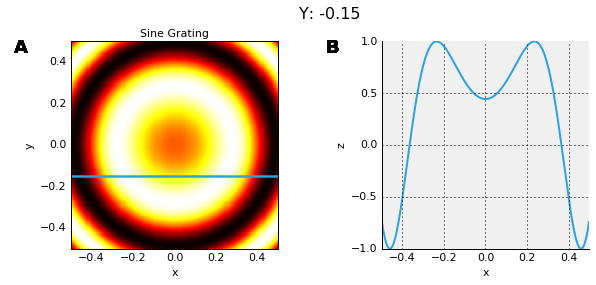
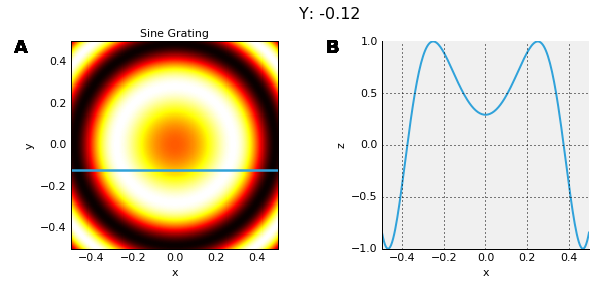
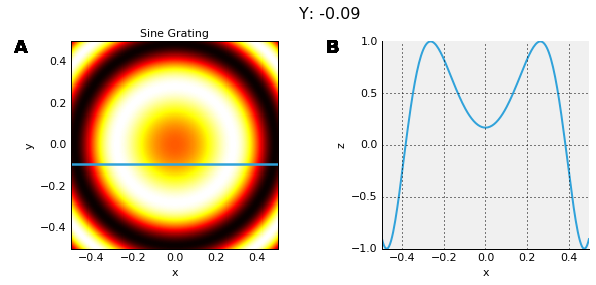
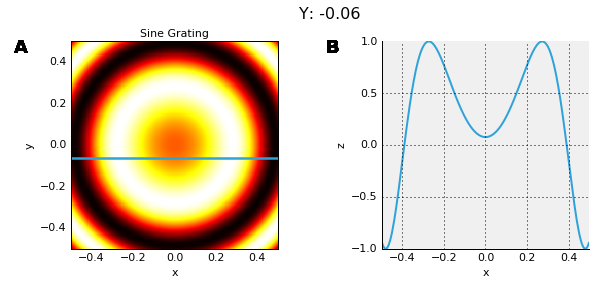
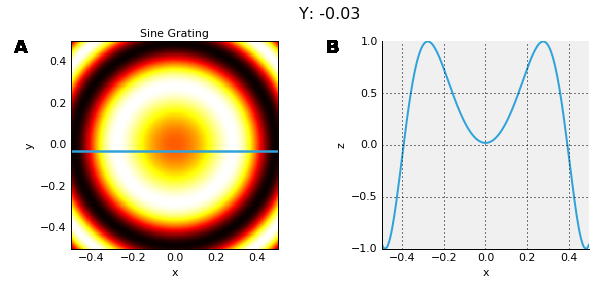
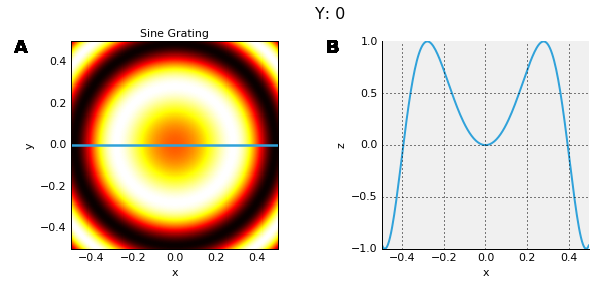
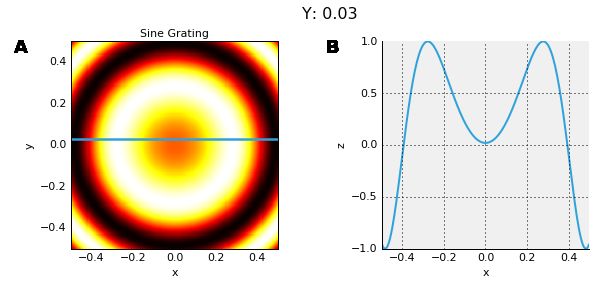
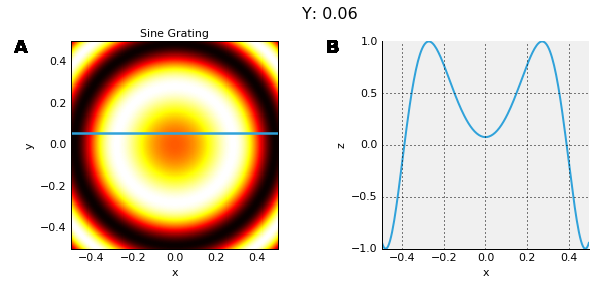
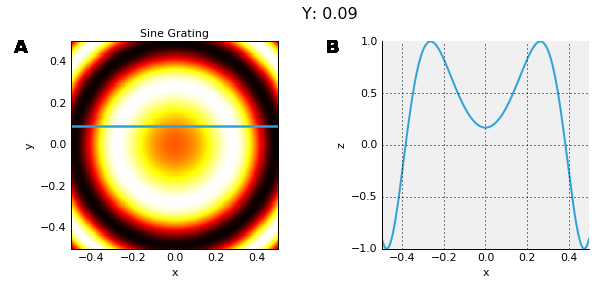
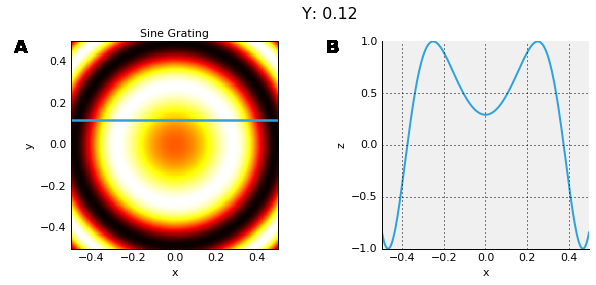
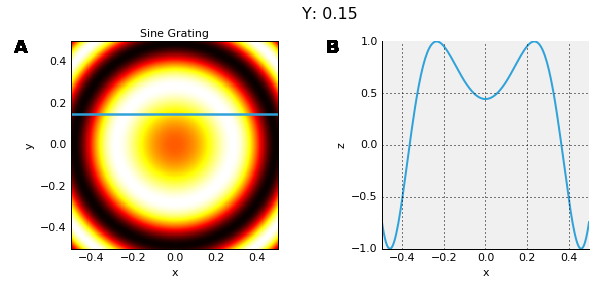
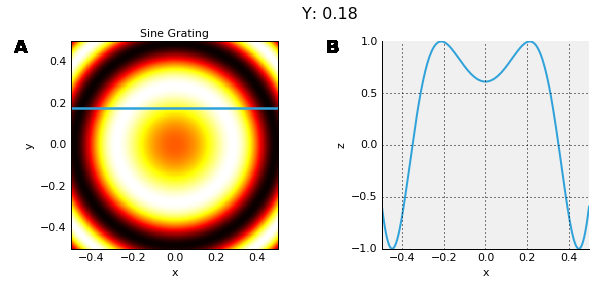
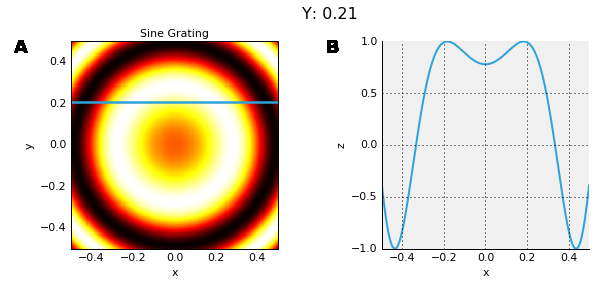
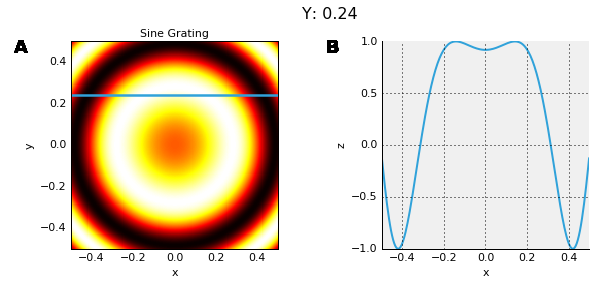
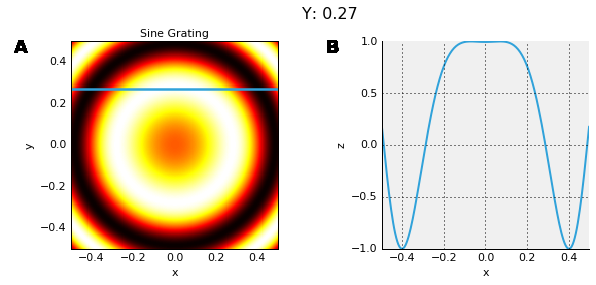
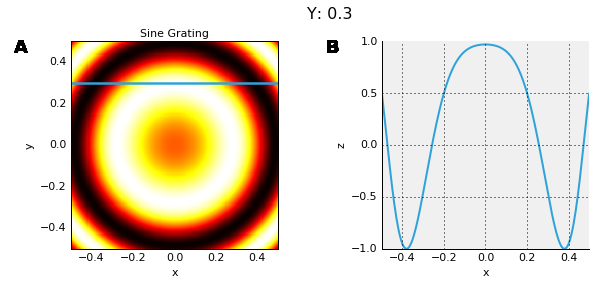

In [9]:
positions = np.linspace(-0.3, 0.3, 21)

hv.HoloMap({y: (grating * hv.HLine(y)) for y in positions}, kdims='Y') + \
hv.HoloMap({y: (grating.sample(y=y))   for y in positions}, kdims='Y')

Here instead of single visualizable objects as above, the "+" here is combining "HoloMaps", which are flexible dictionary-like structures that hold visualizable data for a variety of parameter values.  Here both objects are indexed by a single continuous 'Y' value, but in general they can have any number of dimensions, each of which will result in its own slider widget if that dimension is not selected or sampled before viewing.  E.g. here's an example of a 2-dimensional space, where we declare the dimensions of the parameter space to be explored (``dimensions``) as well as the specific samples to take in this parameter space (``keys``):

:Layout
   .HoloMap.I  :HoloMap   [Phase,Frequency]
      :Image   [x,y]   (z)
   .HoloMap.II :HoloMap   [Phase,Frequency]
      :Curve   [x]   (y)
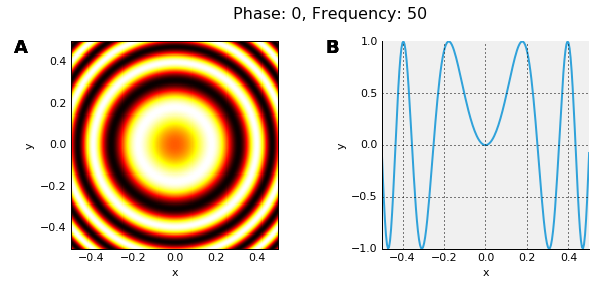
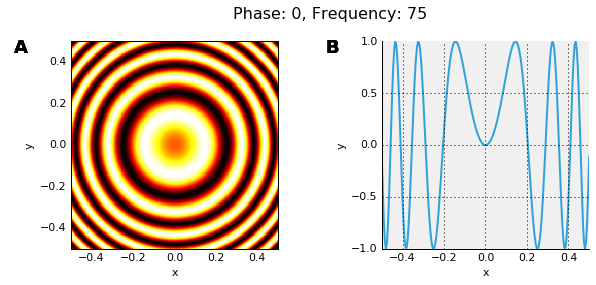
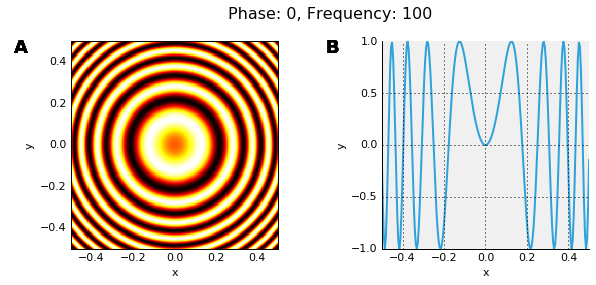
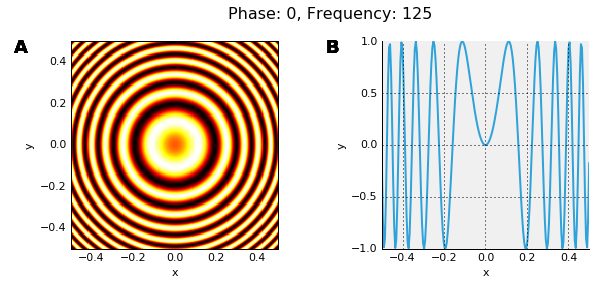
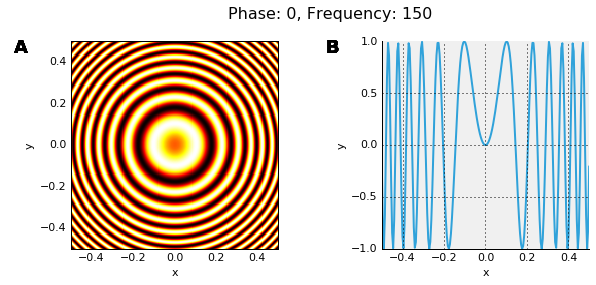
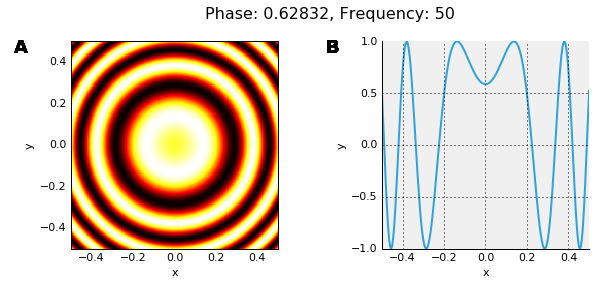
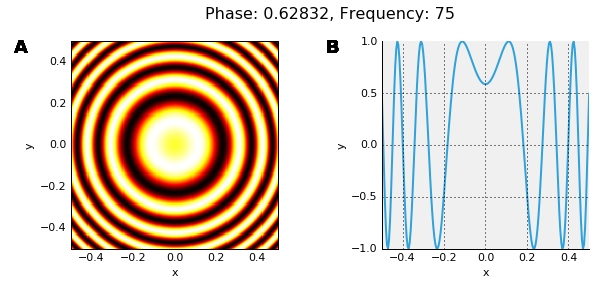
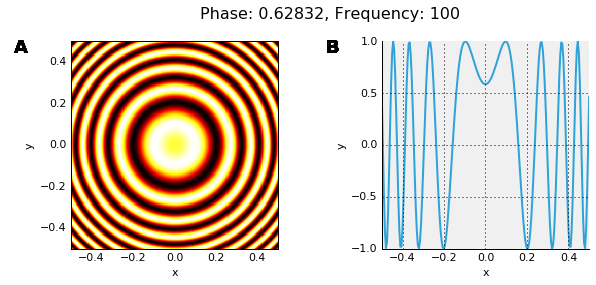
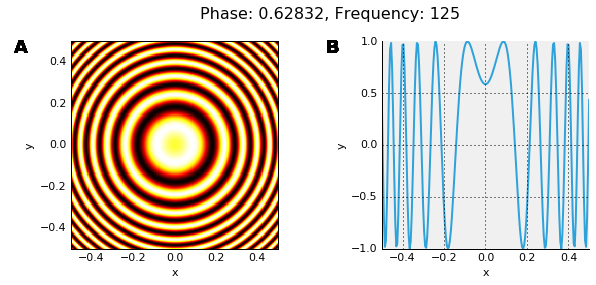
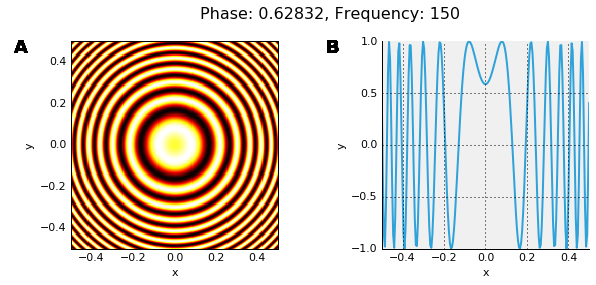
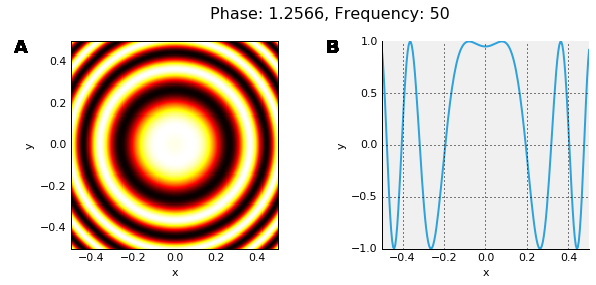
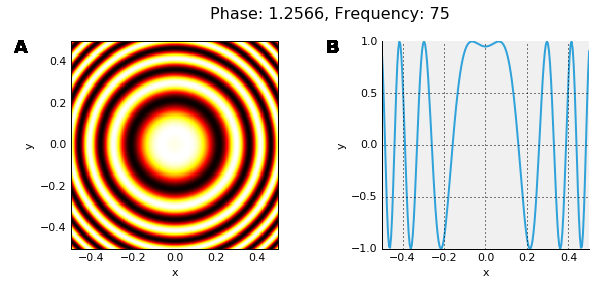
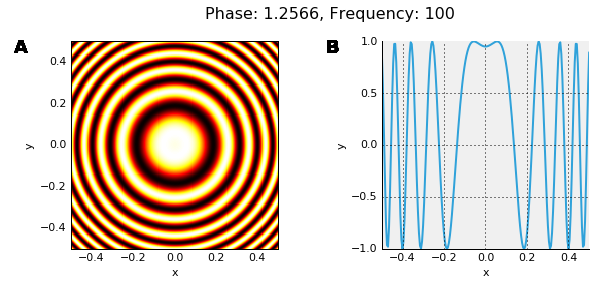
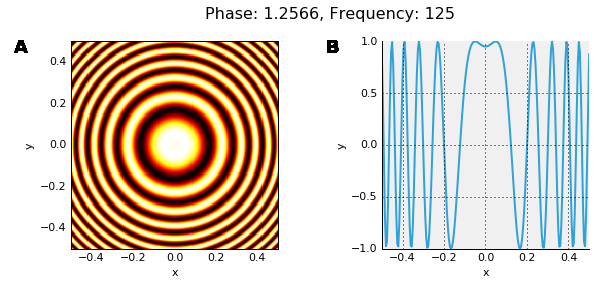
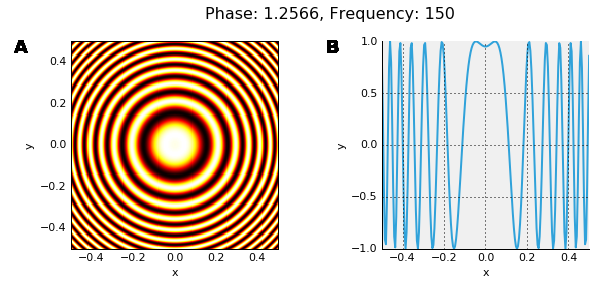
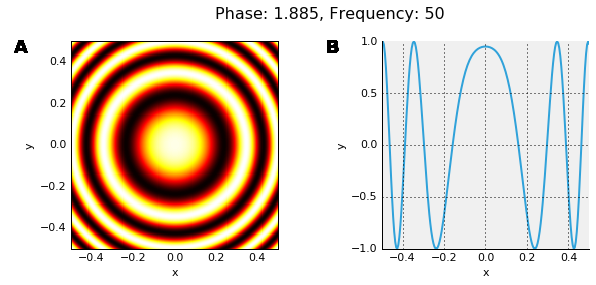
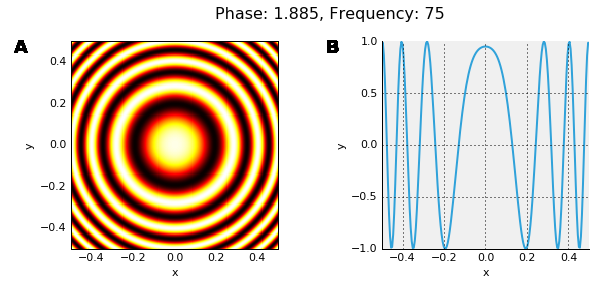
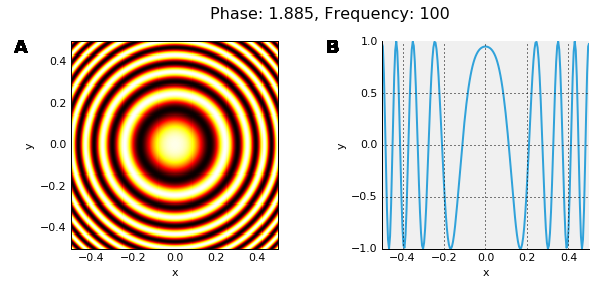
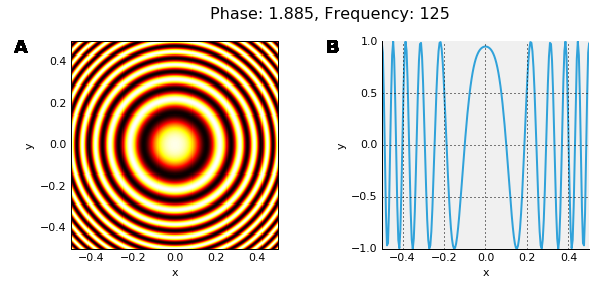
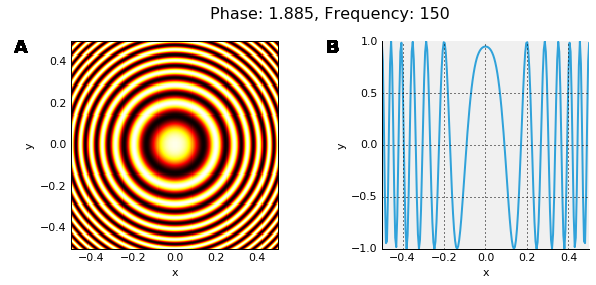
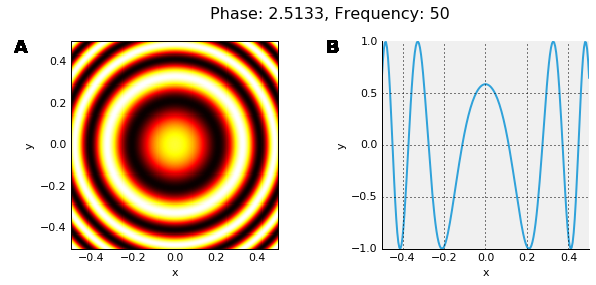
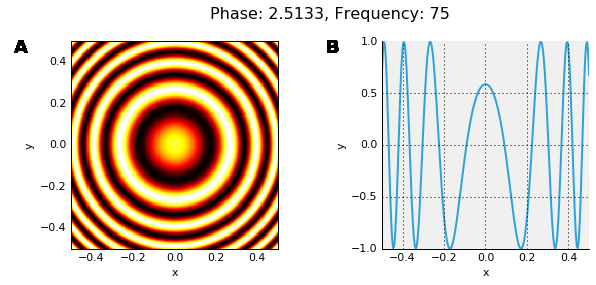
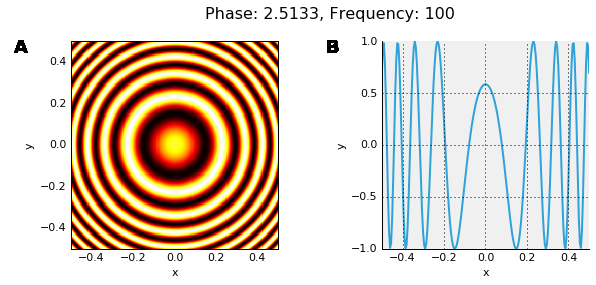
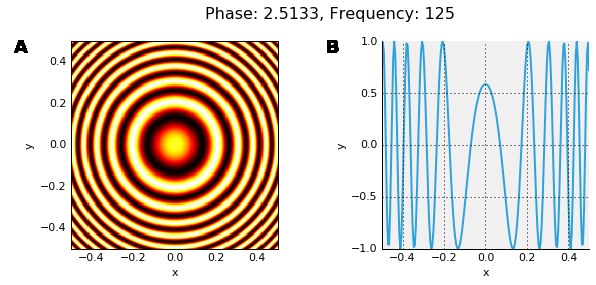
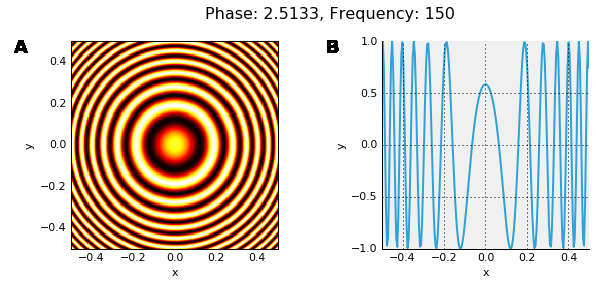
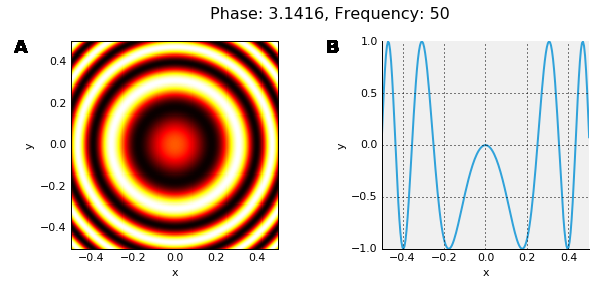
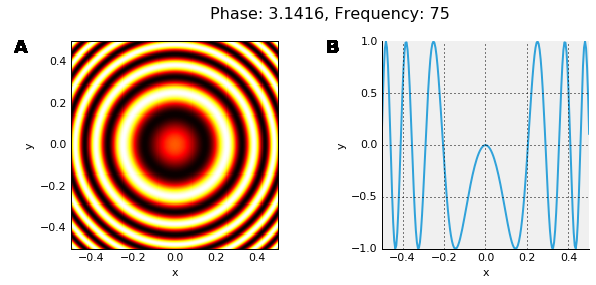
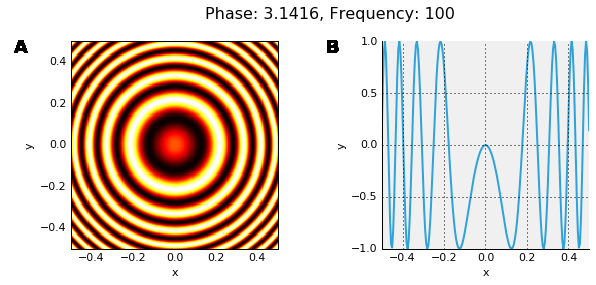
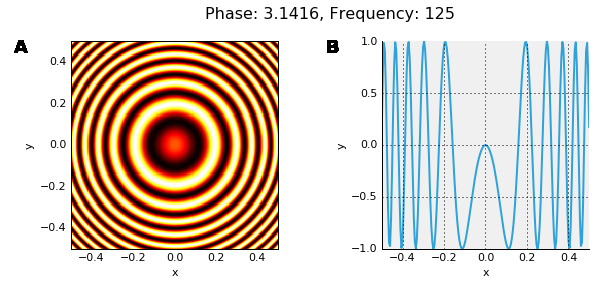
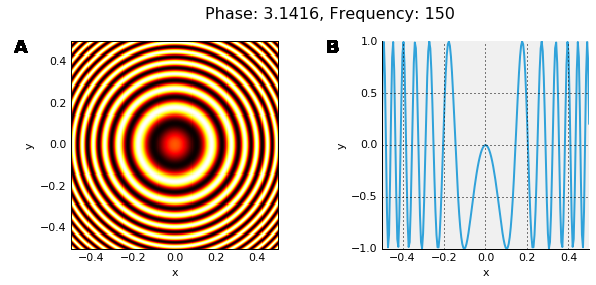
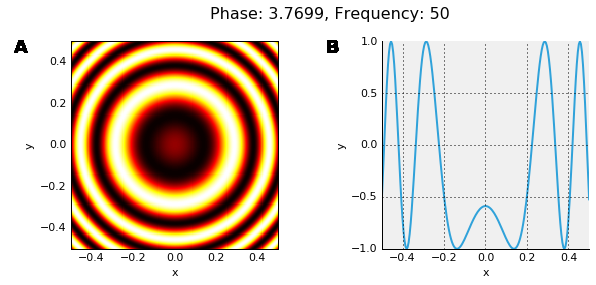
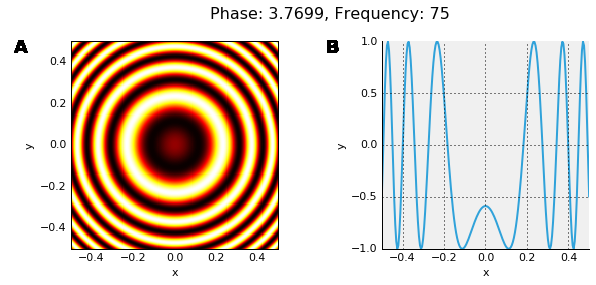
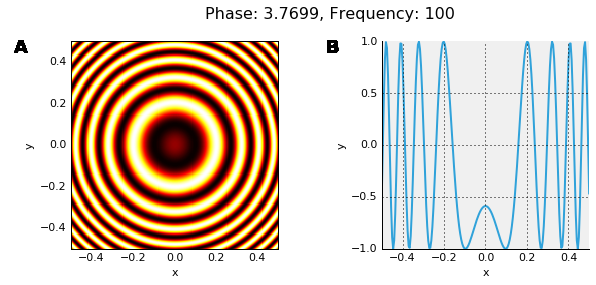
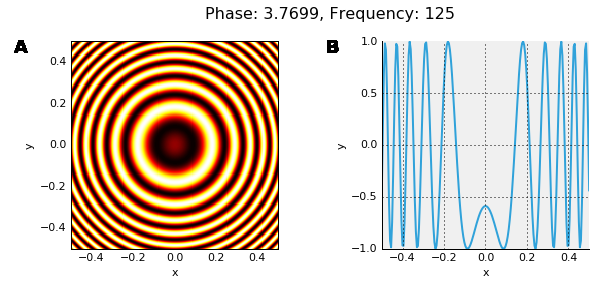
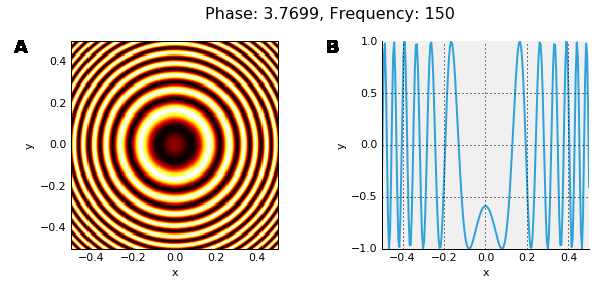
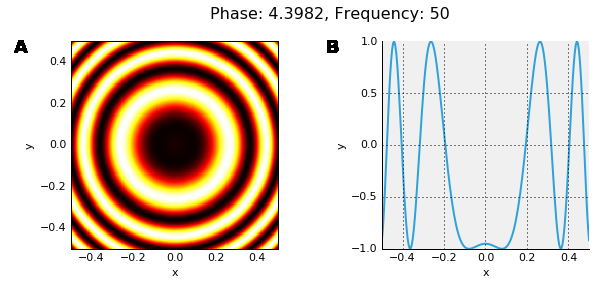
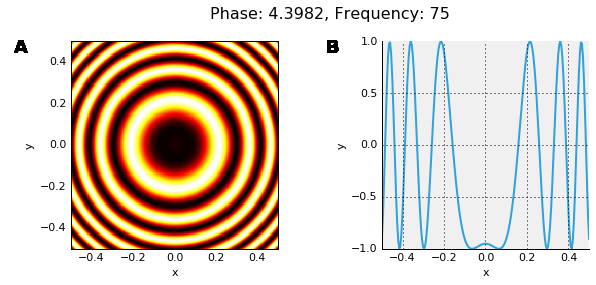
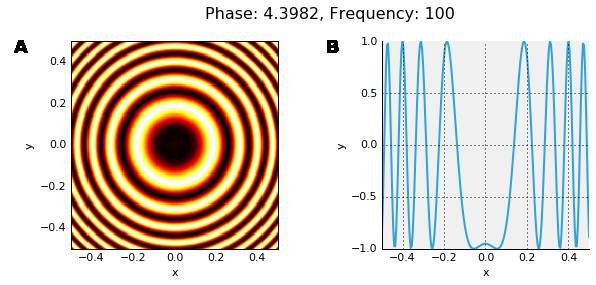
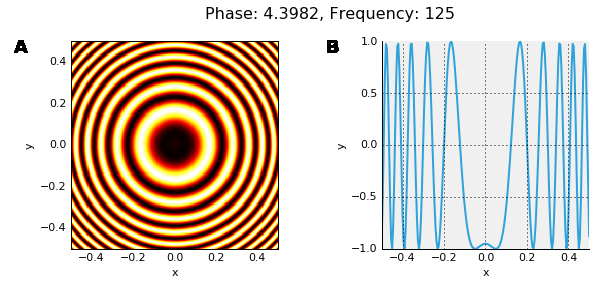
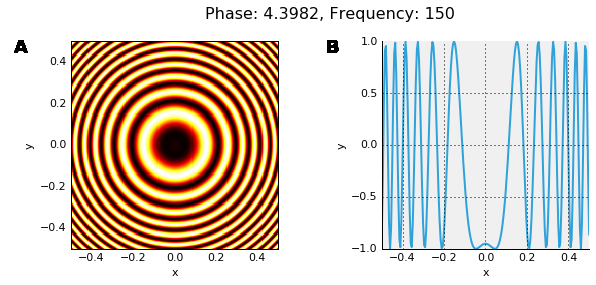
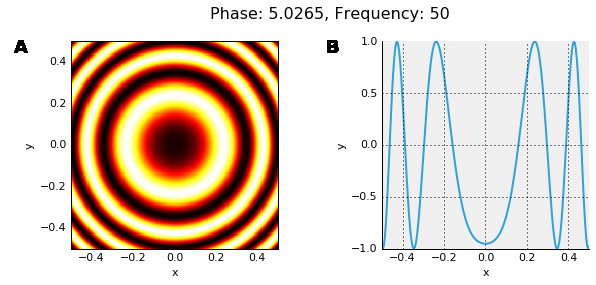
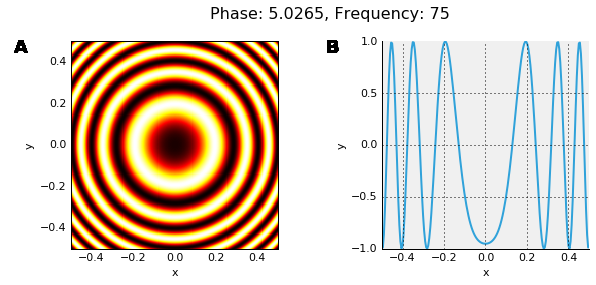
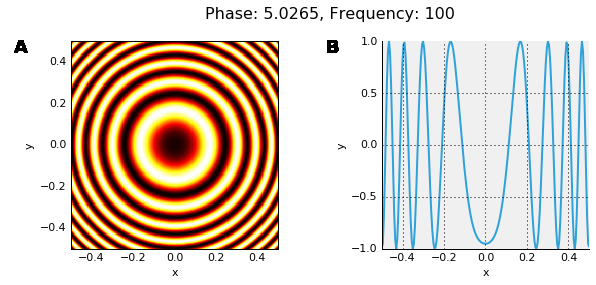
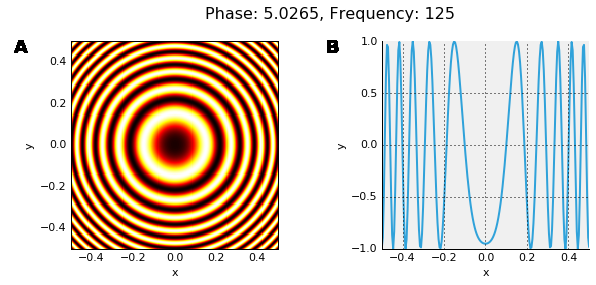
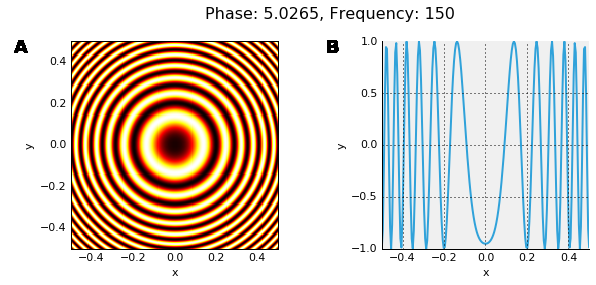
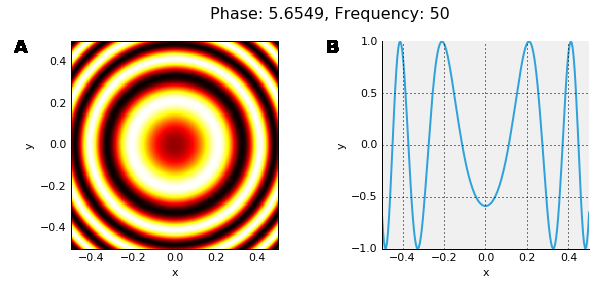
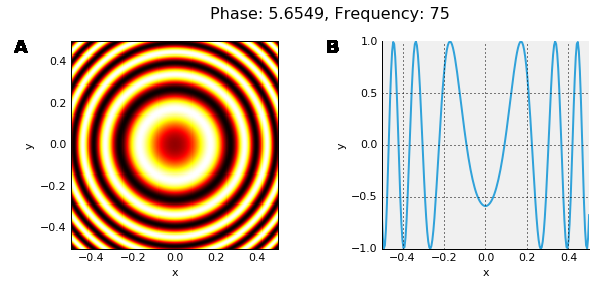
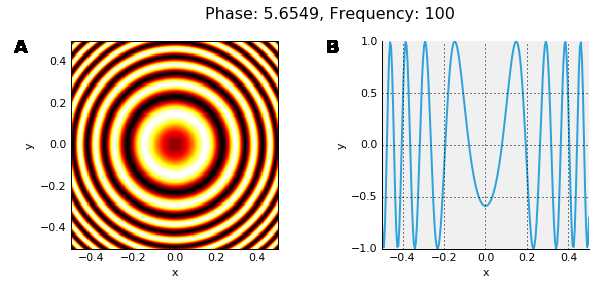
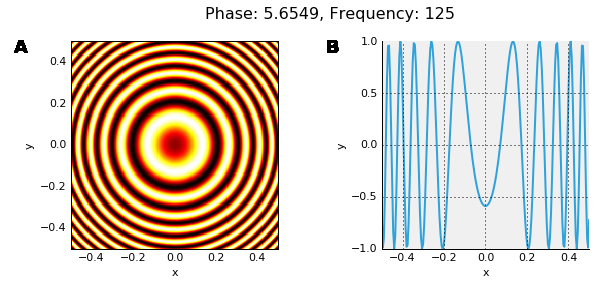
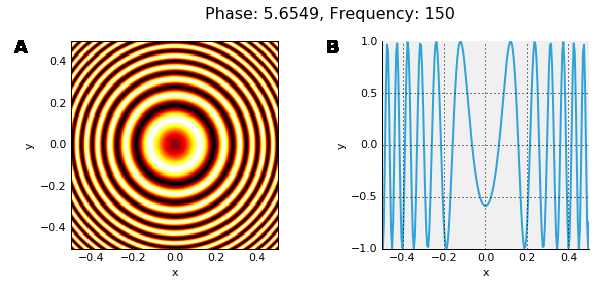
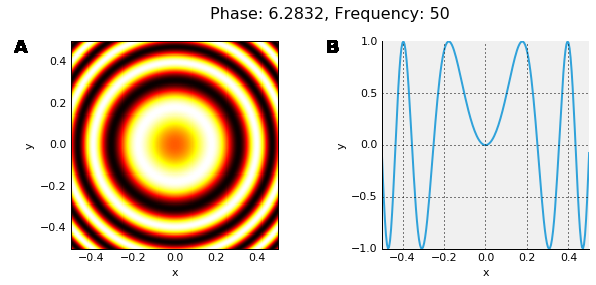
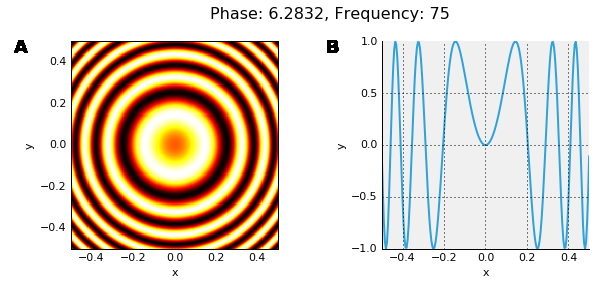
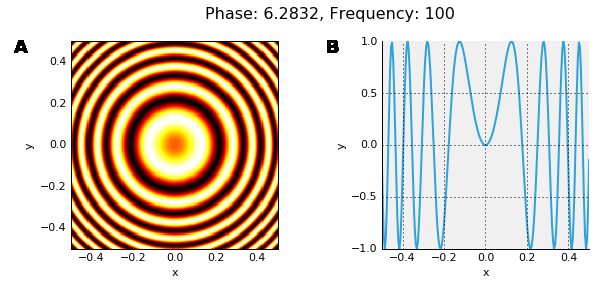
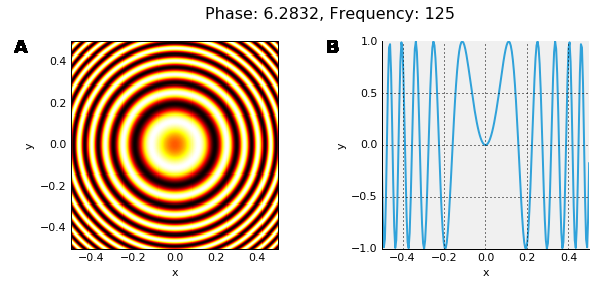
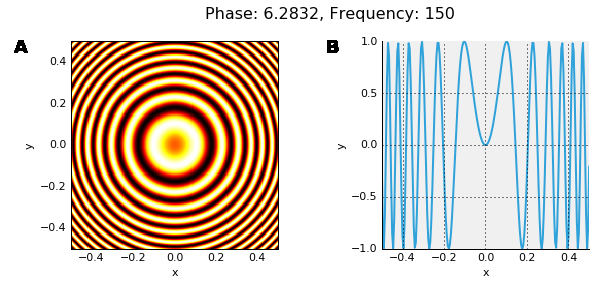

In [10]:
dimensions = ['Phase', 'Frequency']
keys = [(p,f) for p in phases for f in freqs]

hv.HoloMap([(k, hv.Image(sine(grid, *k))) for k in keys], kdims=dimensions) + \
hv.HoloMap([(k, hv.Curve(zip(dist, sine(dist**2, *k)))) for k in keys], kdims=dimensions)

In [17]:
### Exercise: Try varying the amplitude rather than the phase

By default the data will be embedded fully into the output, allowing export to static HTML/JavaScript for distribution, but for parameter spaces too large or using dynamic data, a dynamic callback can be used with a callback that generates the data on the fly using a [DynamicMap](http://holoviews.org/Tutorials/Dynamic_Map.html).


# Setting plot options

HoloViews objects like `grating` above directly contain only your data and associated metadata, not any plotting details.  Metadata like titles and units can be set on the objects either when created or subsequently, as shown using `label` and `relabel` above.  

Other properties of the visualization that are just about the view of it, not the actual data, are not stored on the HoloViews objects, but in a separate data structure.  To make it easy to control such options in the notebook, a special syntax is provided:

:Layout
   .AdjointLayout.Sine_Grating :AdjointLayout
      :Histogram   [z]   (Frequency)
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .Curve.I                    :Curve   [x]   (z)
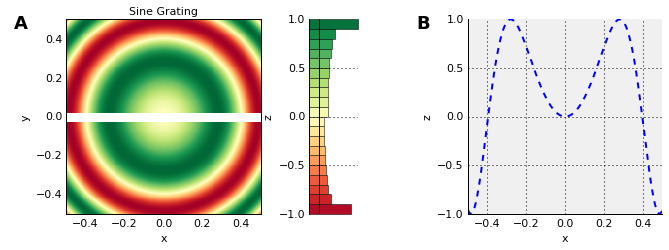

In [11]:
%%opts Image (cmap='RdYlGn') Curve (color='b' linestyle='dashed') HLine (color='white' linewidth=9)
((grating * hv.HLine(y=0)).hist() + grating.sample(y=0))

One advantage of this special "magic" syntax is that the names and values tab complete in the Jupyter notebook (try it!)  

In [12]:
### EXERCISE: Try changing various parameters in the above plot, using tab completion to discover the names and values

Of course, standard Python syntax is also supported, though it is much less succinct:

b':Image   [x,y]   (z)'
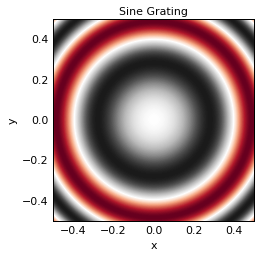

In [13]:
grating(options={'Image':{'style':{'cmap':'RdGy'}}})

## Normalizing your data

HoloViews is designed to make it easy to understand your data. For instance, consider two circular waves with very different amplitudes: 

In [14]:
comparison = hv.Image(sine(grid)) + hv.Image(sine(grid, phase=np.pi)*0.02)

HoloViews ensures that these differences are visible by default, by normalizing across any elements of the same type that are displayed together, and even across the frames of an animation:

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)
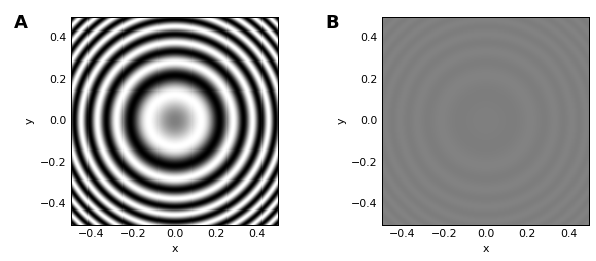

In [15]:
%%opts Image (cmap='gray')
comparison = hv.Image(sine(grid)) + hv.Image(sine(grid, phase=np.pi)*0.02)
comparison

This default visualization makes it clear that the two patterns differ greatly in amplitude. However, it is difficult to see the structure of the low-amplitude wave in **B**.  If you wish to focus on the spatial structure rather than the amplitude, you can instruct HoloViews to normalize data in different axes separately:

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)
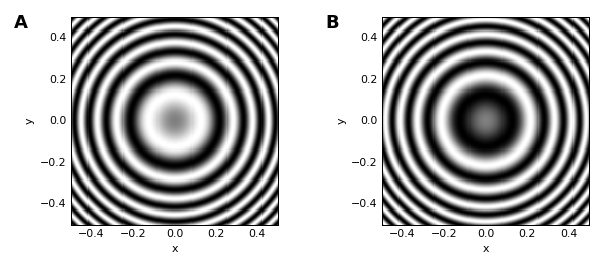

In [16]:
%%opts Image {+axiswise} (cmap='gray')
comparison

Similarly, you could supply ``+framewise`` to tell it to normalize data per frame of an animation, not across all frames as it does by default.  As with any other customization, you can always specify which specific element you want the customization to apply to, even in a complex multiple-subfigure layout.

# Learning more

If you are interested in using HoloViews in your workflow, check out the extensive tutorials at [holoviews.org](http://holoviews.org), and at [geo.holoviews.org](http://geo.holoviews.org/) for geographic applications.  These tutorials cover everything shown above in much more detail, along with how to  
[export the data for a reproducible workflow](http://holoviews.org/Tutorials/Exporting.html), use 
[columnar data](http://holoviews.org/Tutorials/Columnar_Data.html) like Pandas Dataframes, use any of the other [plotting types available](http://holoviews.org/Tutorials/Elements.html), and use any of the other
[container types available](http://holoviews.org/Tutorials/Composing_Data.html).